In [1]:
import numpy as np
import optimizers as opt
import model
import helper_functions as func

# Підготовка
## Дані

In [2]:
bounds_var7 = np.array([
    (0, 5), (-1/3, 1), (-1/3, 1), (-1/3, 1), (-1/3, 1), (-1/3, 1), (-1/3, 1)
])
X_var7, y_var7 = func.get_data(7)

bounds_var12 = np.array([
    (-1, 1), (-1, 1), (1000, 2000), (-200, 200)
])
X_var12, y_var12 = func.get_data(12)

bounds_var16 = np.array([
    (1, 10), (1, 10), (100, 1000)
])
X_var16, y_var16 = func.get_data(16)

## Моделі для регрессії

In [3]:
model7 = model.Model(X_var7, y_var7, model.var7_func)
model12 = model.Model(X_var12, y_var12, model.var12_func)
model16 = model.Model(X_var16, y_var16, model.var16_func)

# Варіант 7
## Алгоритм рою часток

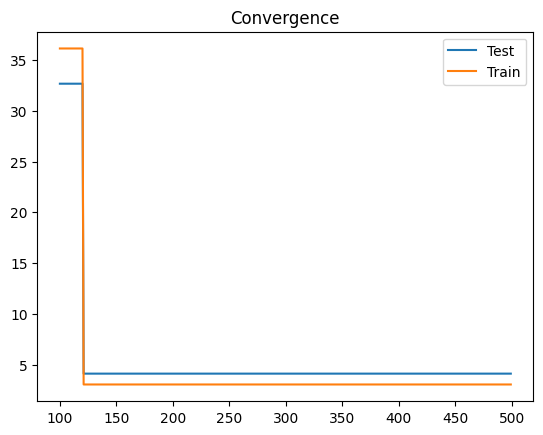

Loss on train set 3.034e+00
Loss on test set 4.102e+00


In [6]:
PSO7 = opt.PSO(1000, len(bounds_var7), 0.1, 2, bounds_var7, -1e-1, 1e-1)
PSO_params7 = PSO7.main_loop(model7, 500, verbose=False, gif_name=r"Gifs\PSO7")
print("Loss on train set %.3e\nLoss on test set %.3e" % (model7.loss(PSO_params7), model7.test_loss(PSO_params7)))

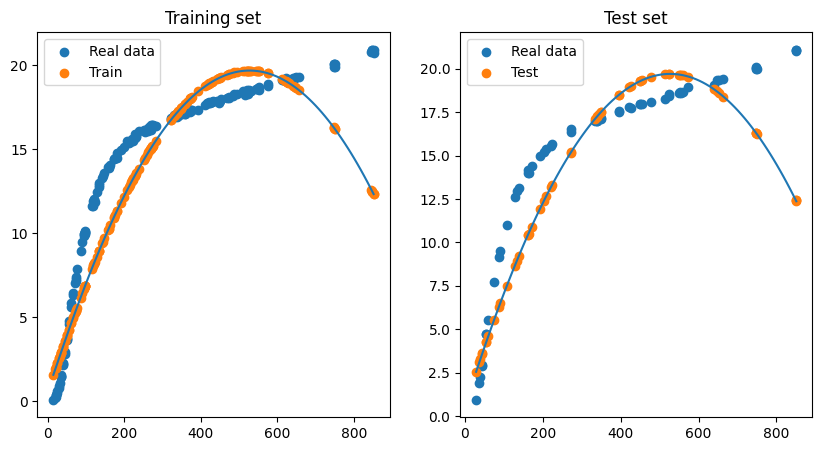

In [7]:
func.plot_results(model7, PSO_params7)

## Алгоритм диференціальної еволюції

d:\Labs\Pchelky\Lab 6\model.py:9: RuntimeWarning: overflow encountered in power
  return (b1 + b2 * x + b3 * x ** 2 + b4 * x ** 3) / (1 + b5 * x + b6 * x ** + b7 ** 3)
d:\Labs\Pchelky\Lab 6\model.py:9: RuntimeWarning: overflow encountered in multiply
  return (b1 + b2 * x + b3 * x ** 2 + b4 * x ** 3) / (1 + b5 * x + b6 * x ** + b7 ** 3)


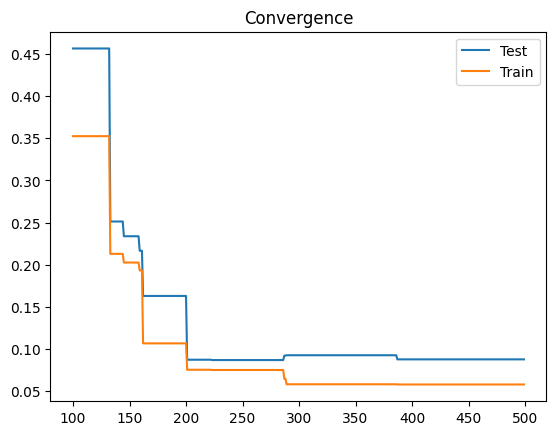

Loss on train set 5.814e-02
Loss on test set 8.790e-02


In [8]:
DE7 = opt.DE(1000, len(bounds_var7), bounds_var7)
DE_params7 = DE7.main_loop(500, 1, 0.5, model7, verbose=False, gif_name=r"Gifs\DE7")
print("Loss on train set %.3e\nLoss on test set %.3e" % (model7.loss(DE_params7), model7.test_loss(DE_params7)))

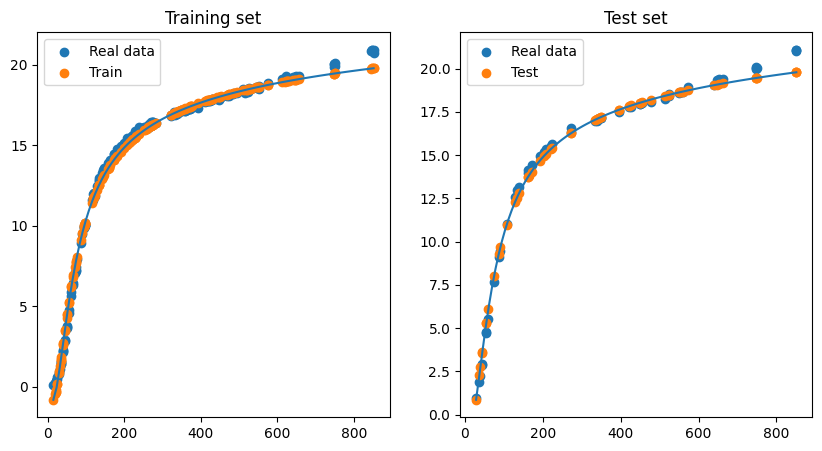

In [9]:
func.plot_results(model7, DE_params7)

# Варіант 12
## Алгоритм рою часток

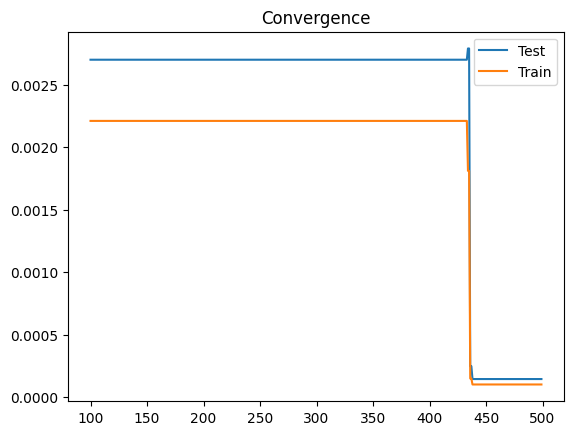

Loss on train set 1.023e-04
Loss on test set 1.458e-04


In [10]:
PSO12 = opt.PSO(100, len(bounds_var12), 1, 3, bounds_var12, -1e-1, 1e-1)
PSO_params12 = PSO12.main_loop(model12, 500, verbose=False, gif_name=r"Gifs\PSO12")
print("Loss on train set %.3e\nLoss on test set %.3e" % (model12.loss(PSO_params12), model12.test_loss(PSO_params12)))

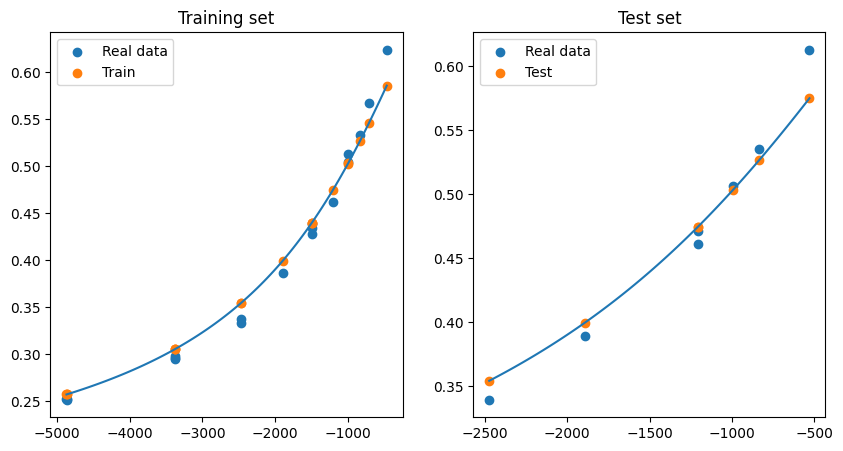

In [11]:
func.plot_results(model12, PSO_params12)

## Алгоритм диференціальної еволюції

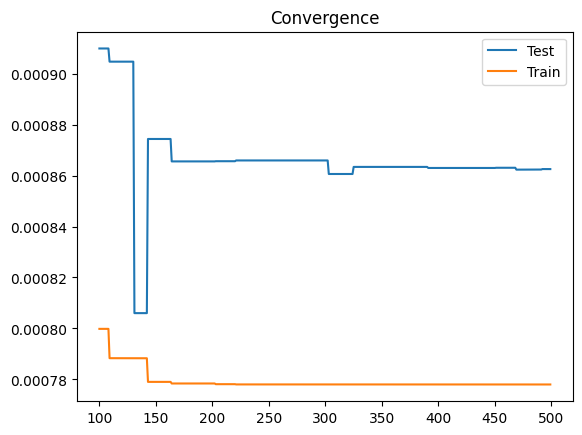

Loss on train set 7.780e-04
Loss on test set 8.626e-04


In [12]:
DE12 = opt.DE(150, len(bounds_var12), bounds_var12)
DE_params12 = DE12.main_loop(500, 1, 0.5, model12, verbose=False, gif_name=r"Gifs\DE12")
print("Loss on train set %.3e\nLoss on test set %.3e" % (model12.loss(DE_params12), model12.test_loss(DE_params12)))

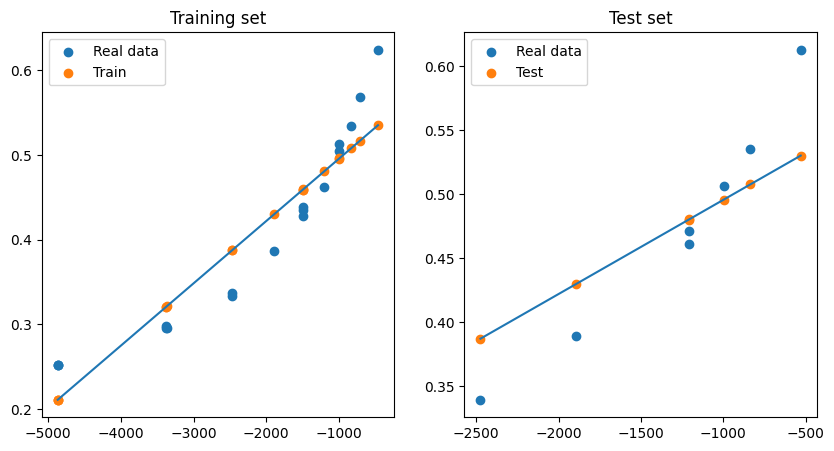

In [13]:
func.plot_results(model12, DE_params12)

# Варіант 16
## Алгоритм рою часток

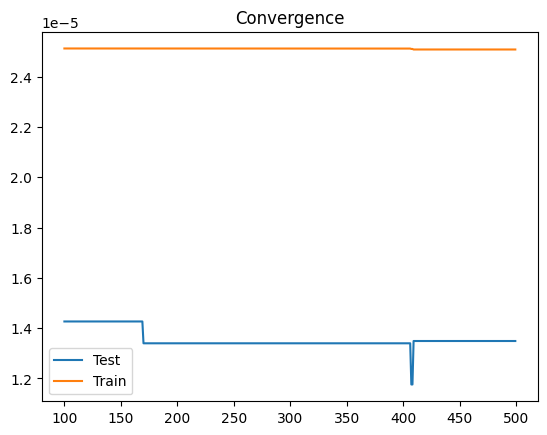

Loss on train set 2.508e-05
Loss on test set 1.349e-05


In [18]:
PSO16 = opt.PSO(100, len(bounds_var16), 1, 3, bounds_var16, -1e-1, 1e-1)
PSO_params16 = PSO16.main_loop(model16, 500, verbose=False, gif_name=r"Gifs\PSO16")
print("Loss on train set %.3e\nLoss on test set %.3e" % (model16.loss(PSO_params16), model16.test_loss(PSO_params16)))

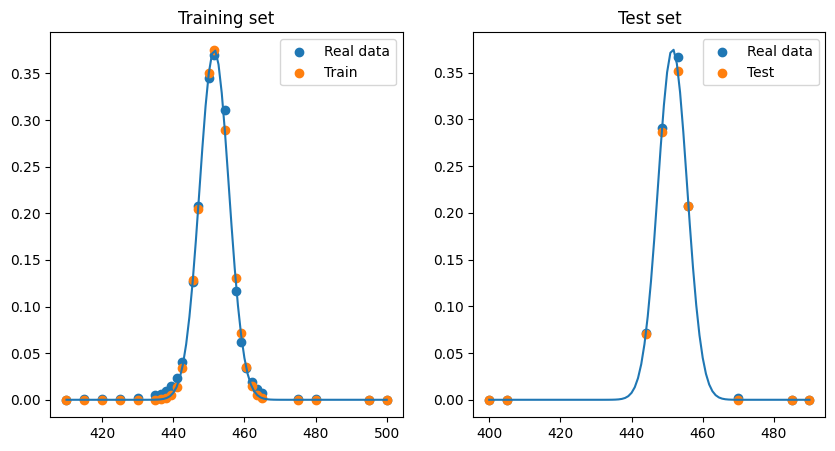

In [19]:
func.plot_results(model16, PSO_params16)

## Алгоритм диференціальної еволюції

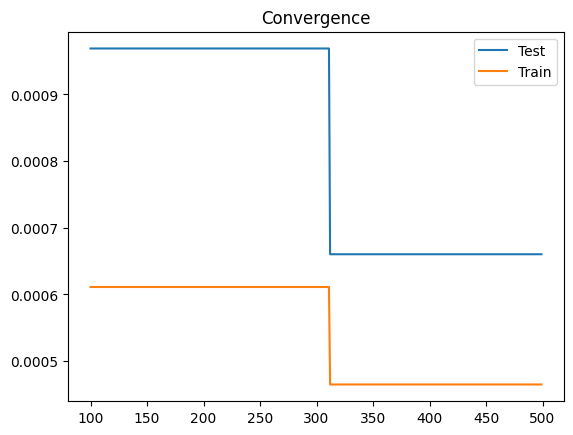

Loss on train set 4.650e-04
Loss on test set 6.603e-04


In [16]:
DE16 = opt.DE(150, len(bounds_var16), bounds_var16)
DE_params16 = DE16.main_loop(500, 1, 0.5, model16, verbose=False, gif_name=r"Gifs\DE16")
print("Loss on train set %.3e\nLoss on test set %.3e" % (model16.loss(DE_params16), model16.test_loss(DE_params16)))

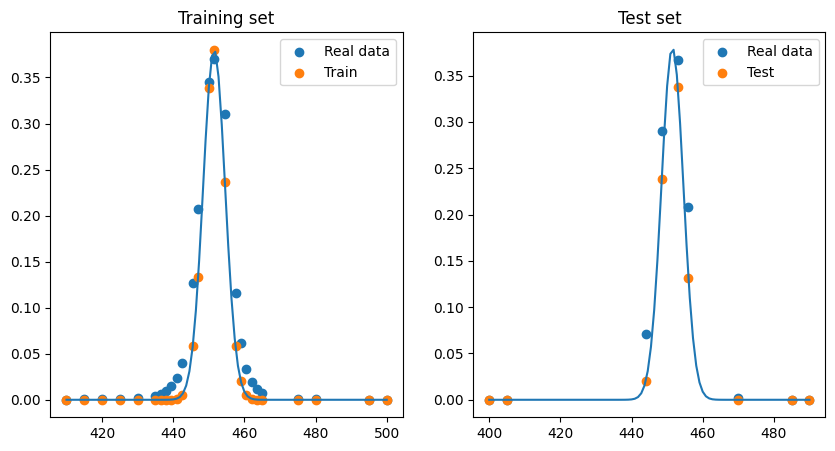

In [17]:
func.plot_results(model16, DE_params16)